In [1]:
import sys, os
sys.path.insert(0, os.path.abspath(".."))

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

from src.preprocess import split_improvements, parse_improvement, clean_text
from src.labels import label_measure


In [10]:
# adjust filename to any EPC CSV you’ve got
df = pd.read_csv("../data/raw/D_EPC_data_2025Q2/2025Q2.csv", nrows=200_000, low_memory=False)

# explode 'IMPROVEMENTS' into rows
records = []
for raw in df["IMPROVEMENTS"].dropna():
    for seg in split_improvements(raw):
        rec = parse_improvement(seg)
        if rec["measure"]:
            rec["label"] = label_measure(rec["measure"])
            records.append(rec)

imp = pd.DataFrame(records)
imp = imp.dropna(subset=["label"]).reset_index(drop=True)
imp["clean"] = imp["measure"].map(clean_text)
imp.head()


,measure,cost,saving,rating,raw,label,clean
0,Floor insulation (suspended floor),"£800 - £1,200",69.0,C,Description: Floor insulation (suspended floor...,insulation,floor insulation suspended floor
1,Solar water heating,"£4,000 - £6,000",45.0,C,Description: Solar water heating; Indicative C...,renewables,solar water heating
2,"Solar photovoltaic panels, 2.5 kWp","£3,500 - £5,500",425.0,B,"Description: Solar photovoltaic panels, 2.5 kW...",renewables,solar photovoltaic panels kwp
3,Replacement glazing units,"£1,000 - £1,400",56.0,C,Description: Replacement glazing units; Indica...,glazing,replacement glazing units
4,Cavity wall insulation,"£500 - £1,500",88.0,C,Description: Cavity wall insulation; Indicativ...,insulation,cavity wall insulation


In [11]:
imp['raw'][0]

'Description: Floor insulation (suspended floor); Indicative Cost: £800 - £1,200; Typical Saving: 69; Energy Rating after improvement: C 75; Environmental Rating after improvement: C 74; Green Deal Eligible: Y'

In [12]:
imp["label"].value_counts()

label
insulation    61964
renewables    54587
heating       13601
lighting       9433
glazing        5774
Name: count, dtype: int64

              precision    recall  f1-score   support

     glazing       1.00      1.00      1.00      1155
     heating       1.00      1.00      1.00      2720
  insulation       1.00      1.00      1.00     12393
    lighting       1.00      1.00      1.00      1887
  renewables       1.00      1.00      1.00     10917

    accuracy                           1.00     29072
   macro avg       1.00      1.00      1.00     29072
weighted avg       1.00      1.00      1.00     29072



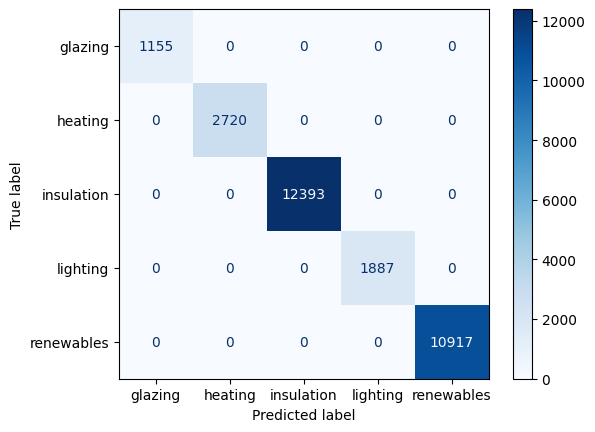

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import ConfusionMatrixDisplay

X = imp["clean"]
y = imp["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

clf = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ("lr", LogisticRegression(max_iter=200, class_weight="balanced"))
])

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=clf.classes_).plot(cmap="Blues")


In [6]:
clf.predict(["replace boiler with condensing boiler and add heating controls"])

array(['heating'], dtype=object)